In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### Reading ANIMELIST.CSV

In [2]:
import os

In [3]:
INPUT_DIR=os.path.join("..","artifacts","raw")

In [4]:
rating_df=pd.read_csv(INPUT_DIR+"/animelist.csv",low_memory=True,usecols=["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
rating_df.shape

(7000000, 3)

### DATA PROCESSING

In [7]:
n_ratings=rating_df["user_id"].value_counts()

In [8]:
n_ratings

user_id
20807    17546
11100    14429
22022    13696
16869     8943
10255     8403
         ...  
13606        1
15566        1
9020         1
17067        1
26           1
Name: count, Length: 21103, dtype: int64

In [9]:
rating_df=rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>400].index)].copy()

In [10]:
rating_df

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
6999995,22944,4214,0
6999996,22944,2000,0
6999997,22944,64,0
6999998,22944,65,0


In [11]:
min_rating=min(rating_df["rating"])
min_rating

0

In [12]:
max_rating=max(rating_df["rating"])
max_rating

10

In [13]:
avg_rating=np.mean(rating_df["rating"])
avg_rating

np.float64(4.072611611849041)

In [14]:
#doing scaling for rating column (Min-Max Scaling)
rating_df["rating"]=rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)


In [15]:
np.mean(rating_df["rating"])

np.float64(0.407261161184904)

In [16]:
## Checking duplicates
rating_df.duplicated().sum()

np.int64(0)

In [17]:
### Checking for null values
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [18]:
#User to user encoding for our model
### userid--->10056 ----->97

user_ids=rating_df["user_id"].unique().tolist()
user2user_encoded={x : i for i,x in enumerate(user_ids)}
user2user_decoded={i : x for i,x in enumerate(user_ids)}
rating_df["user"]=rating_df["user_id"].map(user2user_encoded) #creates another oclumn of user encoded for machine

In [19]:
rating_df

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0
...,...,...,...,...
6999995,22944,4214,0.0,5828
6999996,22944,2000,0.0,5828
6999997,22944,64,0.0,5828
6999998,22944,65,0.0,5828


In [20]:
n_users=len(user2user_encoded)
n_users

5829

In [21]:
## Doing same for anime_id column


anime_ids=rating_df["anime_id"].unique().tolist()
anime2anime_encoded={x : i for i,x in enumerate(anime_ids)}
anime2anime_decoded={i : x for i,x in enumerate(anime_ids)}
rating_df["anime"]=rating_df["anime_id"].map(anime2anime_encoded) #creates another oclumn of user encoded for machine

In [22]:
rating_df

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
6999995,22944,4214,0.0,5828,1574
6999996,22944,2000,0.0,5828,5417
6999997,22944,64,0.0,5828,727
6999998,22944,65,0.0,5828,730


In [23]:
n_anime=len(anime2anime_encoded)
n_anime

17553

In [24]:
## Shuffling data so that our model learns pattern on random data.LearningRateScheduler 
rating_df=rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [25]:
rating_df

,user_id,anime_id,rating,user,anime
0,16418,21797,0.0,4167,2247
1,21090,16051,0.0,5368,2196
2,781,7060,0.0,206,10547
3,21935,31139,0.0,5576,4302
4,7048,37999,0.9,1763,1482
...,...,...,...,...,...
4553275,5929,3011,0.6,1479,6087
4553276,7928,30014,0.0,2002,3188
4553277,7522,777,0.9,1896,193
4553278,12688,38524,0.7,3201,405


In [26]:
X=rating_df[["user","anime"]].values
y=rating_df["rating"]

In [27]:
test_size=1000
train_indices=rating_df.shape[0]-test_size

In [28]:
X_train,X_test,y_train,y_test=(
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [29]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4552280, 2), (1000, 2), (4552280,), (1000,))

In [30]:
type(X_train)

numpy.ndarray

In [31]:
#Storing the input features as a list
X_train_array=[X_train[:,0],X_train[:,1]]
X_test_array=[X_test[:,0],X_test[:,1]]

In [32]:
type(X_test_array)

list

### MODEL ARCHITECTURE

In [33]:
def RecommendorNet():
    embeddiing_size=128  #no of vectors

    user=Input(name="user",shape=[1])

    user_embedding=Embedding(name="user_embedding",input_dim=n_users,output_dim=embeddiing_size)(user) #the embedding layer would be working on input layer

    anime=Input(name="anime",shape=[1])

    anime_embedding=Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embeddiing_size)(anime)

    x=Dot(name="dot_product",normalize=True,axes=2)([user_embedding,anime_embedding]) #similarities between user and anime

    x=Flatten()(x) #Convertws high dimensional vector into single dimensional vector

    x=Dense(1,kernel_initializer="he_normal")(x)
    x=BatchNormalization()(x)
    x=Activation("sigmoid")(x)

    model=Model(inputs=[user,anime],outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer="Adam")

    return model


In [34]:
model=RecommendorNet()

In [35]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    746,112 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,246,784 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,992,902 (11.42 MB)

 Trainable params: 2,992,900 (11.42 MB)

 Non-trainable params: 2 (8.00 B)

In [37]:
start_lr=0.00001
min_lr=0.0001
max_lr=0.00005
batch_size=10000

ramup_epochs=5
sustain_epochs=0
exp_decay=0.8

#for finding best learning rate for our model
def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch+start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay**(epoch-ramup_epochs-sustain_epochs)+min_lr

In [39]:
lr_callback=LearningRateScheduler(lambda epoch:lrfn(epoch),verbose=0)
checkpoint_filepath='./weights.weights.h5'

model_checkpoint=ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping=EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [40]:
my_callbacks=[model_checkpoint,lr_callback,early_stopping]

In [41]:
history=model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 59s 121ms/step - loss: 0.8044 - mae: 0.3840 - mse: 0.1995 - val_loss: 0.7897 - val_mae: 0.3870 - val_mse: 0.1977 - learning_rate: 1.0000e-05
Epoch 2/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - loss: 0.8002 - mae: 0.3825 - mse: 0.1979 - val_loss: 0.7983 - val_mae: 0.3884 - val_mse: 0.2002 - learning_rate: 1.8000e-05
Epoch 3/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 46s 99ms/step - loss: 0.7936 - mae: 0.3802 - mse: 0.1954 - val_loss: 0.7944 - val_mae: 0.3875 - val_mse: 0.1988 - learning_rate: 2.6000e-05
Epoch 4/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - loss: 0.7830 - mae: 0.3762 - mse: 0.1912 - val_loss: 0.7884 - val_mae: 0.3857 - val_mse: 0.1965 - learning_rate: 3.4000e-05
Epoch 5/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 46s 100ms/step - loss: 0.7688 - mae: 0.3707 - mse: 0.1856 - val_loss: 0.7767 - val_mae: 0.3813 - val_mse: 0.1919 - learning_rate: 4.2000e-05
Epoch 6/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - loss: 0.7457 - mae: 0.3607 - mse: 0.1760 

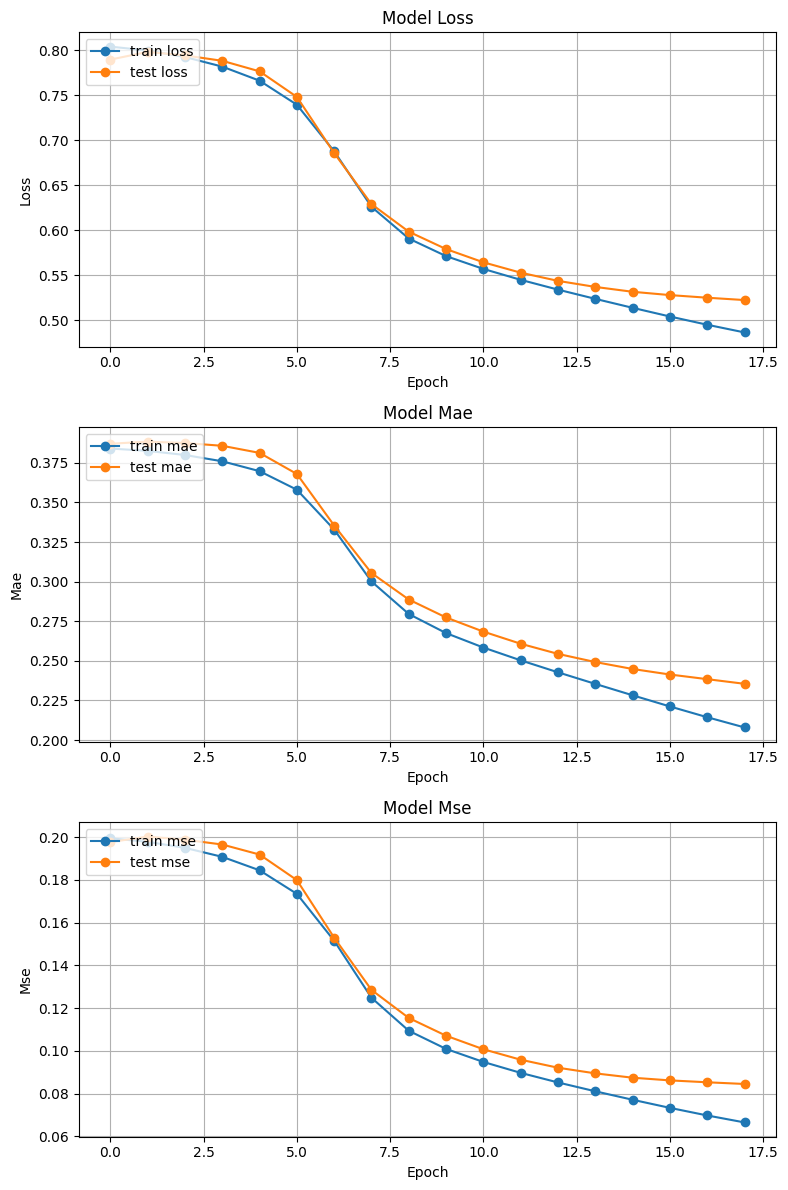

In [42]:
metrics=["loss","mae","mse"]

fig,axes=plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))

for i,metric in enumerate(metrics):
    ax=axes[i]
    ax.plot(history.history[metric][0:-2],marker="o",label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2],marker="o",label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()